In [2]:
import pandas as pd
import numpy as np
from numba import jit, types
from numba.typed import Dict
import time
from scipy.optimize import least_squares
from curve_fitting import (residuals_multicountry_multistep,
                           residuals_multicountry_singlestep,
                           residuals_singlecountry_multistep,
                           residuals_singlecountry_singlestep)

data = pd.read_csv("data/consolidated/consolidated_data.csv")


In [3]:
betas_order = {}
counter = 0
for cc in data["Country Code"].sort_values().unique():
    betas_order[cc] = counter
    counter += 1
n_countries = len(betas_order)
beta_0_idx = 7


In [4]:
x_0 = np.zeros(beta_0_idx+len(betas_order))
x_0[:7] = [800,0,0,0,0.05,0.05,-5]
x_0[7:] = -0.2
bounds = (np.zeros(len(x_0)),-0.05*np.ones(len(x_0)))
bounds[1][0:7] = np.inf
bounds[1][6] = 0

bounds[0][:] = -np.inf
bounds[0][6] = -10
bounds[0][4:6] = 0
bounds[0][7:] = -0.4



bootstrap procedure:
- repeat n_resample times:
    - draw n_sample_countries with replacement from all countries
    - calculate least squares fit of coefficients to data
    - fill in missing beta_i s by individual curve fitting with fixed common coefficients

In [58]:
# bootstrapping the coefficients
import pickle
n_sample_countries = len(data["Country Code"].unique())
n_resample = 100

bootstrap_fits = []
val_residuals = np.empty(0)

for i_r in range(n_resample):
    print("resampling step",i_r+1)
    sampled_countries = np.random.choice(data["Country Code"].sort_values().unique(), n_sample_countries)
    list_of_data = []
    for sc in sampled_countries:
        list_of_data.append(data.loc[data["Country Code"]==sc])
    data_sampled = pd.concat(list_of_data,ignore_index=True)
    beta_idx = np.array([*map(betas_order.get, data_sampled["Country Code"].to_numpy(dtype=str))],np.int64) 

    t0 = time.time()

    res_lsq = least_squares(residuals_multicountry_multistep,x_0,verbose=0,bounds=bounds,max_nfev=100,args = (beta_idx,beta_0_idx,data_sampled["Country Code"].to_numpy(dtype=str),
                            data_sampled["Year"].to_numpy(),data_sampled["POP-DENS"].to_numpy(),data_sampled["URBAN-POP-PERC"].to_numpy(),
                            data_sampled["URBAN-POP-DENS"].to_numpy(),data_sampled["GDP_rising"].to_numpy(dtype=int),data_sampled["GDP_falling"].to_numpy(dtype=int),
                            data_sampled["GDP-PER-CAP"].to_numpy(),data_sampled["VEHICLE-STOCK-LAST-PER-CAP"].to_numpy(),data_sampled["VEHICLE-STOCK-PER-CAP"].to_numpy()))
   
    t1 = time.time()
    print("main fit time: ",t1-t0)

    #fit beta for unsampled countries
    #which countries were not fitted?
    countries_not_fitted = [i for i in data["Country Code"].sort_values().unique() if i not in np.unique(sampled_countries)]
    for c in countries_not_fitted:
        country_data = data.loc[data["Country Code"]==c]
        res_lsq_c = least_squares(residuals_singlecountry_multistep,[-0.2],verbose=0,bounds=[-0.4,-0.05],max_nfev=100,args = (*res_lsq.x[0:7],beta_0_idx,
                            country_data["POP-DENS"].to_numpy(),country_data["URBAN-POP-PERC"].to_numpy(),
                            country_data["URBAN-POP-DENS"].to_numpy(),country_data["GDP_rising"].to_numpy(),country_data["GDP_falling"].to_numpy(),
                            country_data["GDP-PER-CAP"].to_numpy(),country_data["VEHICLE-STOCK-LAST-PER-CAP"].to_numpy(),country_data["VEHICLE-STOCK-PER-CAP"].to_numpy()))

        res_lsq.x[beta_0_idx+betas_order[c]] = res_lsq_c.x[0]
        val_resi = residuals_singlecountry_singlestep(res_lsq_c.x,*res_lsq.x[0:7],
                            country_data["POP-DENS"].to_numpy(),country_data["URBAN-POP-PERC"].to_numpy(),
                            country_data["URBAN-POP-DENS"].to_numpy(),country_data["GDP_rising"].to_numpy(),country_data["GDP_falling"].to_numpy(),
                            country_data["GDP-PER-CAP"].to_numpy(),country_data["VEHICLE-STOCK-LAST-PER-CAP"].to_numpy(),country_data["VEHICLE-STOCK-PER-CAP"].to_numpy())
        if np.min(val_resi) < -200:
            print("very large residual for ",c)
        val_residuals = np.concatenate((val_residuals,val_resi))


    bootstrap_fits.append(res_lsq.x)
    t2 = time.time()
    print("small fit + save time: ",t2-t1)

print("fitting to all training data")
#fit on all data
beta_idx = np.array([*map(betas_order.get, data["Country Code"].to_numpy(dtype=str))],np.int64)
res_lsq = least_squares(residuals_multicountry_multistep,x_0,verbose=0,bounds=bounds,max_nfev=100,args = (beta_idx,data["Country Code"].to_numpy(dtype=str),
                            data["Year"].to_numpy(),data["POP-DENS"].to_numpy(),data["URBAN-POP-PERC"].to_numpy(),
                            data["URBAN-POP-DENS"].to_numpy(),data["GDP_rising"].to_numpy(dtype=int),data["GDP_falling"].to_numpy(dtype=int),
                            data["GDP-PER-CAP"].to_numpy(),data["VEHICLE-STOCK-LAST-PER-CAP"].to_numpy(),data["VEHICLE-STOCK-PER-CAP"].to_numpy()))

train_residuals = residuals_multicountry_singlestep(res_lsq.x,beta_idx,data["Country Code"].to_numpy(dtype=str),
                            data["POP-DENS"].to_numpy(),data["URBAN-POP-PERC"].to_numpy(),
                            data["URBAN-POP-DENS"].to_numpy(),data["GDP_rising"].to_numpy(dtype=int),data["GDP_falling"].to_numpy(dtype=int),
                            data["GDP-PER-CAP"].to_numpy(),data["VEHICLE-STOCK-LAST-PER-CAP"].to_numpy(),data["VEHICLE-STOCK-PER-CAP"].to_numpy())

preds = train_residuals + data["VEHICLE-STOCK-PER-CAP"].to_numpy()

print(np.min(val_residuals),np.min(train_residuals))

print("computing residuals")

# Take percentiles of the training- and validation residuals to enable
  # comparisons between them
val_residuals_p = np.percentile(val_residuals, q = np.arange(101))
train_residuals_p = np.percentile(train_residuals, q = np.arange(101))

# Compute the .632+ bootstrap estimate for the sample noise and bias
no_information_error = np.mean(np.abs(np.random.permutation(data["VEHICLE-STOCK-PER-CAP"].to_numpy()) - \
    np.random.permutation(preds)))
generalisation = np.abs(val_residuals_p.mean() - train_residuals_p.mean())
no_information_val = np.abs(no_information_error - train_residuals_p)
relative_overfitting_rate = np.mean(generalisation / no_information_val)
weight = .632 / (1 - .368 * relative_overfitting_rate)
residuals = (1 - weight) * train_residuals_p + weight * val_residuals_p

print("pickling")

with open("results/bootstrap_fits_one_step.pickle", "wb") as fp:   #Pickling
    pickle.dump(bootstrap_fits, fp)

with open("results/prediction_residuals_one_step.pickle", "wb") as fp:   #Pickling
    pickle.dump(residuals, fp)

print("done")



resampling step 1
main fit time:  2.4746110439300537
small fit + save time:  0.0860588550567627
resampling step 2
main fit time:  2.1268069744110107
small fit + save time:  0.09393095970153809
resampling step 3
main fit time:  2.4933061599731445
small fit + save time:  0.08237791061401367
resampling step 4
main fit time:  2.390368938446045
small fit + save time:  0.0749351978302002
resampling step 5
main fit time:  2.306043863296509
small fit + save time:  0.10050821304321289
resampling step 6
main fit time:  2.350337028503418
small fit + save time:  0.0854651927947998
resampling step 7
main fit time:  2.4125478267669678
small fit + save time:  0.08644914627075195
resampling step 8
main fit time:  2.5632567405700684
small fit + save time:  0.09641814231872559
resampling step 9
main fit time:  2.320004940032959
small fit + save time:  0.0945580005645752
resampling step 10
main fit time:  2.384164810180664
small fit + save time:  0.10152006149291992
resampling step 11
main fit time:  2.1

6.71375282183029

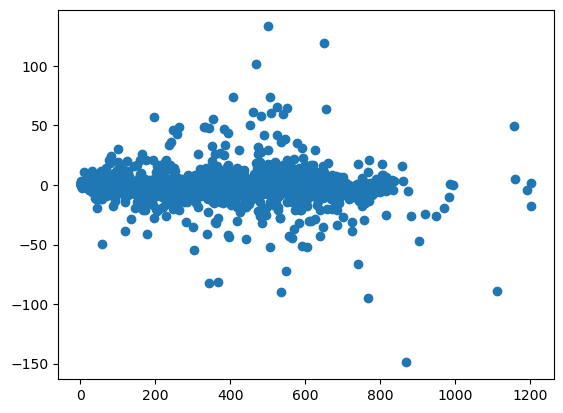

In [57]:
import matplotlib.pyplot as plt
plt.scatter( data["VEHICLE-STOCK-PER-CAP"].to_numpy(),train_residuals)

np.mean(np.sqrt(np.square(train_residuals)))